# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
#set the seed to assure you get the same answers
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df= pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

number of unique users in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

proportion of users converted.

In [6]:
len(df.query('converted == 1')) / df.shape[0]

0.11965919355605512

number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
len(df.query('group == "treatment" and landing_page != "new_page"  or  group == "control" and landing_page != "old_page"'))

3893

Do any of the rows have missing values?

In [8]:
df.query('group == "treatment" and landing_page == "new_page"').isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2= df.query('(group == "control" and landing_page == "old_page") or (group == "treatment" and landing_page == "new_page")')

In [10]:
df2.shape

(290585, 5)

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [12]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

find if there are repeated IDs

In [13]:
df2[df2.duplicated(subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2.loc[df2.user_id.duplicated(), :]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2= df2.drop_duplicates(subset= ['user_id'])

In [16]:
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted


What is the probability of an individual converting regardless of the page they receive?<br><br>


In [17]:
len(df2.query('converted == 1')) / len(df2)

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
d1= len(df2.query('group == "control"  and  converted == 1')) / len(df2.query('group == "control"'))
d1

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
d2= len(df2.query('group == "treatment"  and  converted == 1')) / len(df2.query('group == "treatment"'))
d2

0.11880806551510564

In [46]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff= d2 - d1
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [21]:
len(df2.query('landing_page == "new_page"')) / len(df2)

0.5000619442226688

>**based on the data on hand now.. the new page has done worse than old page (but almost no change)..
 so it's better to wait and collect some more data**

<a id='ab_test'></a>
## Part II - A/B Test

Now do the A/B Test to apply statistics to find out which page is better.  


I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.  

>**
𝐻0: P𝑜𝑙𝑑 >= Pnew ....
𝐻1: P𝑜𝑙𝑑 < Pnew 
**

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



a. What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [22]:
# assuming that 𝑝𝑛𝑒𝑤 =  𝑝_𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛 >> so p_new will be calculated on the whole df2
p_new= df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [23]:
# assuming that p_old =  𝑝_𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛 >> so p_new will be calculated on the whole df2
p_old= df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [24]:
n_new= len(df2.query('group == "treatment" '))
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old= len(df2.query('group == "control" '))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [56]:
new_page_converted= np.random.choice([0,1] , size=n_new , p=[(1-p_new), p_new])
new_page_converted

array([1, 1, 0, ..., 1, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> 

In [57]:
old_page_converted= np.random.choice([0,1] , size=n_old , p=[(1-p_old), p_old])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for simulated samples from the parts (e) and (f) above. 

In [58]:
obs_diff2= new_page_converted.mean() - old_page_converted.mean()
obs_diff2
# note: if obs_diff2 is positive.. this supports the alternative hypothesis

-0.0013236314132070021


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
then will store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [59]:
# Sampling distribution 
p_diffs = []

for i in range(10000):
    new_page_converted= np.random.choice([0,1] , size=n_new , p=[1-p_new, p_new])
    old_page_converted= np.random.choice([0,1] , size=n_old , p=[1-p_old, p_old])
    obs_diff3= new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(obs_diff3)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**. 


Text(0,0.5,'frequency')

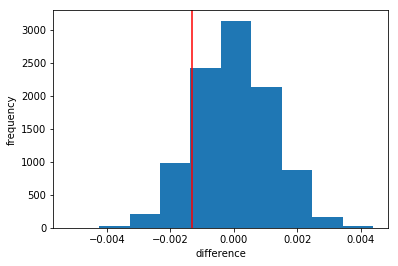

In [60]:
plt.hist(p_diffs)
plt.axvline(obs_diff2, color='r')
plt.xlabel('difference')
plt.ylabel('frequency')
# H0: P𝑜𝑙𝑑 >= Pnew .... H1: P𝑜𝑙𝑑 < Pnew

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [1]:
(p_diffs > obs_diff2).mean()
# this is the p-value
# remember that big p-value means that we can't reject H0 >> so H0 is true
# --> so we stay at our assumption of: P𝑜𝑙𝑑 >= Pnew

NameError: name 'p_diffs' is not defined

**l. Using Built-in Methods for Hypothesis Testing**<br>
Will try to use built-in to achieve similar results.  

- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page

In [32]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('converted == 1  and  landing_page == "old_page"'))

# number of conversions with the new_page
convert_new =len(df2.query('converted == 1  and  landing_page == "new_page"'))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page == "old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page == "new_page"'))


### The two-sample z-test
We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



In [33]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print('z_score: ', z_score, '\n', 'p_value: ', p_value)

z_score:  -1.31092419842 
 p_value:  0.905058312759


* **to reject H0 z-score need to be more than (1.95996) .. but it's (-1.311) .. so we can't reject H0**
> **which means that the new page didn't help imporve the conversion rates.**

* **also the p-value here is same with the one calulated manually**
> **which give the same results .. that the new page didn't help imporve the conversion rates.**

<a id='regression'></a>
### Part III - A regression approach

I will get the same result achieved in the A/B test in Part II above by performing regression.<br><br> 



**b.** First need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
df2['intercept']= 1

df2[['2', 'ab_page']]= pd.get_dummies(df2['group'])
df2= df2.drop(columns=['2'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [35]:
y= df2['converted']
x= df2[['intercept', 'ab_page']]

model= sm.Logit(y, x)
results= model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of model below.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-26 16:24 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


In [37]:
np.exp(-0.0150)
# people who recieved 'treatment' are .985 more likely to convert
# (same as)people who didn't recieve 'treatment' are 1.015 more likely to convert

0.98511193960306265

> * **p-value associated with ab_page: 0.1899 (bigger than the Type I error rate (0.05))**
> * **p-value in partII: 0.6349**
 ____________
> * **H0 in logistic regression: there is no relation between X variables and Y variable (two-sided)**
> * **H0 in partII: old page results to higher conversion rates than new page (one-sided)**

**f.** Considering other things that might influence whether or not an individual converts.

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


>* **other factors in the dataset is 'landing_page' (but won't use it as it assosiated with 'group')**
>* **if possible I would suggest gathering more data about the users (like age, gender, location)**
>* **other factors to consider also might be the (click through rate)**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [39]:
# Read the countries.csv
cdf= pd.read_csv('countries.csv')
cdf.head(1)

,user_id,country
0,834778,UK


In [40]:
# Join with the df2 dataframe
df_merged= df2.merge(cdf, on='user_id')
df_merged.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US


In [41]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] =pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [63]:
# Fit your model, and summarize the results
y2= df_merged['converted']
# in x2 I dropped 'CA' to make it the baseline
x2= df_merged[['intercept', 'UK', 'US']]
# in model2 I used OLS becase there are 3 variables not 2.. so it's multi linear not logistic
model2= sm.Logit(y2, x2)
results2= model2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-26 17:21 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

statistical conclusion:

>**users from UK are .0053 more likely to convert (compared to users from CA)**

>**users from US are .0042 more likely to convert (compared to users from CA)**

practical conclusion:

>**we shouldn't care much about which country users belong to... as it almost doesn't affect the model**

**h. Fit your model and obtain the results**<br> 
Now will look at an interaction between page and country to see if are there significant effects on conversion.

In [43]:
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US']*df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_ab_page,US_ab_page,UK_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [62]:
y3= df_merged['converted']
# dropped 'CA' to make it the baseline
x3= df_merged[['intercept','ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']]
# used OLS becase there are 3 variables not 2.. so it's multi linear not logistic
model3= sm.Logit(y3, x3)
results3= model3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-26 17:21 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

statistical conclusion:

>**the coefficient parameters are still low.. which indicates that using the new interactions columns didn't make new difference in results**

practical conclusion:

>**we shouldn't care much about which country users belong to... as it almost doesn't affect the model**

*after the previous analysis we conclude that the old page has higher conversion rate.